In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that o

In [2]:
triplexes = pd.read_csv('basetriples_bal2.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,100,R.C.11.R.A.38.R.A.46.,-_-_-,23.88_30.7_12.63,0,0,1,0,0,...,0,0,0,0,0,0,0,5,1,0
1,1b23.cif1_R,0,R.MIA.37.R.U.43.R.C.51.,-_-_-,21.84_30.76_50.04,0,1,0,0,0,...,1,0,0,0,1,0,0,7,2,0
2,1b23.cif1_R,123,R.A.14.R.G.15.R.A.22.,-_-_-,5.15_7.01_6.62,1,0,0,1,0,...,0,0,0,0,0,0,0,4,0,0
3,1b23.cif1_R,110,R.4SU.8.R.G.15.R.PSU.39.,-_-_-,12.32_29.65_29.39,0,0,1,0,0,...,0,0,0,1,1,0,0,4,0,0
4,1b23.cif1_R,111,R.4SU.8.R.A.14.R.A.46.,tWH_t.W_cSS,10.04_12.76_4.86,0,0,1,0,0,...,0,0,0,0,0,0,0,5,1,1


In [4]:
triplexes.shape

(10769, 477)

In [3]:
### !!!!! необходимые данные

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [4]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    
    
    
def probability_density(y_prob, y):
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')
    plt.show()


In [5]:
#используемая модель
rf_classifier_cv = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

TEST_GROUPS Counter({'3j7q.cif1_5': 381, '3j79.cif1_A': 282, '3j7p.cif1_S2': 223, '4v88.cif1_A6': 186, '6az1.cif1_1': 173, '5xxu.cif1_2': 140, '5xyi.cif1_2': 127, '6d9j.cif1_2': 113, '1u6b.cif1_B': 24, '4v9f.cif1_9': 22, '5fdv.cif1_1B': 21, '3j7o.cif1_7': 19, '5xy3.cif1_3': 19, '4r4v.cif1_A': 18, '1yfg.cif1_A': 17, '4qk8.cif1_A': 16, '3ivk.cif1_M': 15, '3hhn.cif1_E': 12, '4y1j.cif1_A': 11, '6d9j.cif1_7': 11, '1gax.cif1_D': 10, '2azx.cif1_D': 10, '3wfs.cif1_A': 10, '4pr6.cif1_B': 10, '5axm.cif1_P': 10, '1il2.cif1_C': 9, '1qf6.cif1_B': 9, '1qu2.cif1_T': 9, '1y27.cif1_X': 9, '2du3.cif1_D': 9, '2xd0.cif1_W': 9, '3d0u.cif1_A': 9, '3u4m.cif1_B': 9, '4fen.cif1_B': 9, '5l4o.cif1_A': 9, '5mgp.cif1_x': 9, '2gdi.cif1_X': 8, '3oxe.cif1_A': 8, '4jrc.cif1_B': 8, '4qei.cif1_C': 8, '4tue.cif1_QV': 8, '5hr6.cif1_C': 8, '6az3.cif1_5': 8, '1mzp.cif1_B': 7, '3jcs.cif1_3': 7, '4ato.cif1_G': 7, '5lzs.cif1_2': 7, '5ud5.cif1_C': 7, '1s03.cif1_B': 6, '2bte.cif1_B': 6, '2il9.cif1_A': 6, '3npq.cif1_A': 6, '4lck.

CONFUSION MATRIX By chain:  1s03.cif1_B
[[4 0]
 [0 2]]

110 1.U.1246.1.U.1971.1.A.1975. -_tWH_- 74.13_9.93_70.92 PROBA:  0.5004809087836978
111 1.A.251.1.A.783.1.G.837. -_cWW_t.S 6.55_11.99_8.66 PROBA:  0.42158410747753067
111 1.A.256.1.U.963.1.U.971. cHW_-_cWW 7.86_14.8_10.14 PROBA:  0.47581903078148385
111 1.A.1134.1.G.1172.1.A.1235. cWW_tSS_- 13.09_4.52_11.5 PROBA:  0.43743005957592146
111 1.C.1510.1.A.1515.1.U.2033. tHW_cSS_- 12.01_6.03_12.25 PROBA:  0.40737123293917177
111 1.G.1526.1.A.1548.1.OMC.1866. tSH_-_cWW 9.59_7.1_10.45 PROBA:  0.36223964947751436
111 1.A.1696.1.U.1779.1.A.1933. cWW_cSW_- 9.95_9.85_10.92 PROBA:  0.3697067885401521
111 1.A.1884.1.G.2010.1.U.2026. tWS_cWW_- 10.18_10.9_9.62 PROBA:  0.44352674671932263
111 1.A.1941.1.C.2009.1.G.2027. -_cWW_tWS 9.65_10.42_9.69 PROBA:  0.4974140624007754
CONFUSION MATRIX By chain:  6az1.cif1_1
[[88  1]
 [ 8 76]]

110 A.A.33.A.U.69.A.C.70. -_cSH_- 13.47_6.97_16.94 PROBA:  0.8919644161537402
CONFUSION MATRIX By chain:  3oxe.cif1_A


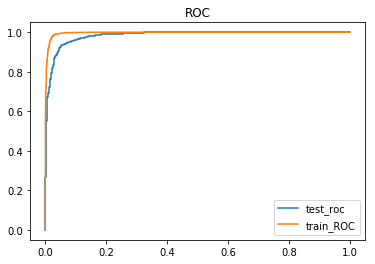

Probability density for train


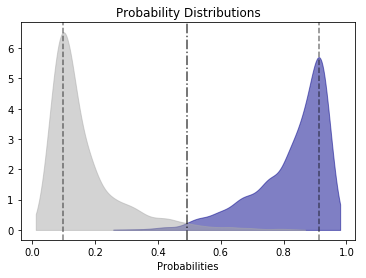

Probability density for test


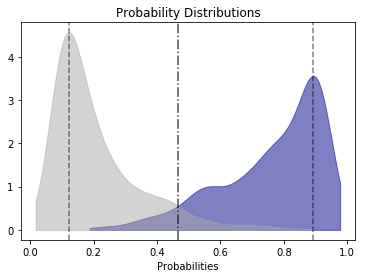


[[1087   54]
 [  81  932]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1087   54  1141
1            81  932  1013
All        1168  986  2154


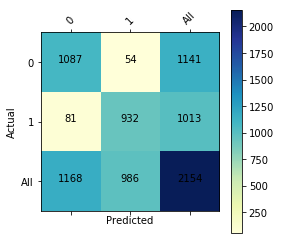


REPORT
             precision    recall  f1-score   support

          0       0.93      0.95      0.94      1141
          1       0.95      0.92      0.93      1013

avg / total       0.94      0.94      0.94      2154

ACCURACY =  0.9373259052924791
-----------------
TEST_GROUPS Counter({'4v9f.cif1_0': 330, '4ioa.cif1_X': 286, '5tbw.cif1_1': 270, '5j7l.cif1_AA': 186, '5ool.cif1_A': 166, '6eri.cif1_BA': 161, '6az3.cif1_1': 117, '3j9m.cif1_AA': 94, '5oql.cif1_1': 46, '3igi.cif1_A': 21, '3pdr.cif1_X': 20, '5t5h.cif1_D': 19, '5xxb.cif1_3': 19, '3j79.cif1_B': 18, '6az3.cif1_8': 17, '4yaz.cif1_R': 16, '5lys.cif1_B': 15, '3f2x.cif1_X': 11, '4wj4.cif1_B': 11, '5wt1.cif1_C': 11, '2der.cif1_D': 10, '3amu.cif1_B': 10, '3dil.cif1_A': 10, '3iwn.cif1_A': 10, '3ski.cif1_A': 10, '1evv.cif1_A': 9, '3rkf.cif1_C': 9, '3wqy.cif1_C': 9, '4v90.cif1_AV': 9, '5d8h.cif1_A': 9, '5e6m.cif1_C': 9, '5jup.cif1_EC': 9, '5t5h.cif1_C': 9, '6cb3.cif1_B': 9, '6ck5.cif1_A': 9, '1b23.cif1_R': 8, '1mms.cif1_C': 8, '3al

110 1.A.656.1.G.1300.1.U.1439. -_-_cWW 76.76_78.83_11.01 PROBA:  0.5060680018071391
110 1.A.692.1.G.2429.1.C.2600. -_cWW_- 81.33_10.8_70.82 PROBA:  0.5170778656307826
111 1.C.497.1.G.616.1.A.3274. cWW_tSW_- 10.86_9.8_11.03 PROBA:  0.4700666295183239
111 1.A.498.1.U.615.1.A.3273. cWW_-_cSW 10.68_11.27_9.46 PROBA:  0.42339043476294763
111 1.U.776.1.U.2719.1.C.2737. cHW_-_cWW 8.25_13.31_7.89 PROBA:  0.494801952852001
111 1.G.1713.1.G.1727.1.A.1731. -_cSS_tSH 11.57_3.84_9.7 PROBA:  0.47370798701841826
111 1.C.2151.1.U.2193.1.A.2243. -_cWH_tSW 11.81_9.33_8.86 PROBA:  0.1644299385696435
111 1.C.2374.1.U.2822.1.U.2868. tHW_cWW_- 9.47_10.87_10.17 PROBA:  0.48356987231076604
112 1.G.909.1.U.919.1.A.2515. cWW_-_- 10.4_52.6_43.6 PROBA:  0.6287150547223839
112 1.G.303.1.C.312.1.A.1150. cWW_-_- 10.69_111.37_102.52 PROBA:  0.5016190595228432
112 1.G.1713.1.G.2918.1.C.2928. -_cWW_- 101.38_10.51_104.16 PROBA:  0.7360770346310348
CONFUSION MATRIX By chain:  5tbw.cif1_1
[[131   5]
 [  6 128]]

CONFUSION

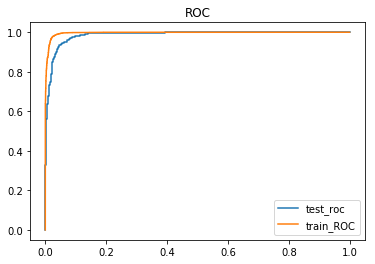

Probability density for train


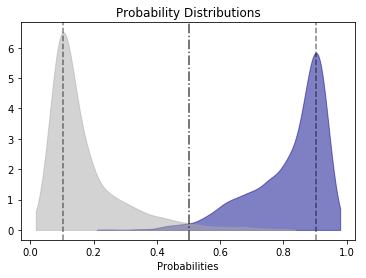

Probability density for test


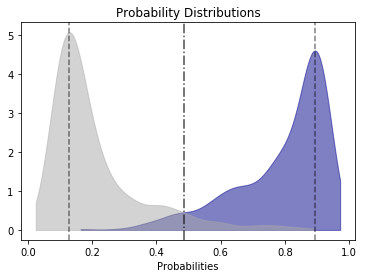


[[1065   66]
 [  58  965]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1065    66  1131
1            58   965  1023
All        1123  1031  2154


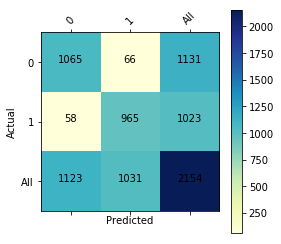


REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.94      1131
          1       0.94      0.94      0.94      1023

avg / total       0.94      0.94      0.94      2154

ACCURACY =  0.9424326833797586
-----------------
TEST_GROUPS Counter({'4y4o.cif1_2A': 321, '6eri.cif1_AA': 295, '5xxb.cif1_1': 246, '6d9j.cif1_5': 212, '5o5j.cif1_A': 166, '3jam.cif1_2': 151, '5mrc.cif1_aa': 126, '6az3.cif1_2': 83, '5t5h.cif1_B': 80, '4ioa.cif1_Y': 20, '5xym.cif1_B': 19, '6ek0.cif1_L7': 19, '6ha1.cif1_B': 18, '6d90.cif1_4': 17, '1c0a.cif1_B': 15, '4plx.cif1_A': 15, '1h4s.cif1_T': 11, '4yye.cif1_C': 11, '1fir.cif1_A': 10, '4p5j.cif1_A': 10, '4v8n.cif1_CV': 10, '4yco.cif1_D': 10, '5o2r.cif1_x': 10, '5ool.cif1_B': 10, '1j1u.cif1_B': 9, '2qus.cif1_A': 9, '2xdb.cif1_G': 9, '3eph.cif1_E': 9, '4m6d.cif1_H': 9, '4mgn.cif1_B': 9, '4rdx.cif1_C': 9, '4y1m.cif1_B': 9, '5xy3.cif1_4': 9, '6az3.cif1_4': 9, '1y26.cif1_X': 8, '3jbv.cif1_W': 8, '3w3s.cif1_B': 8, '4rzd

110 1.G.2420.1.A.2481.1.U.2492. -_cWW_- 65.55_10.94_72.63 PROBA:  0.7717558507853348
110 1.U.408.1.A.2887.1.U.2895. -_cWW_- 95.29_11.12_100.9 PROBA:  0.6595441361091565
110 1.A.39.1.U.44.1.G.120. -_-_- 11.69_80.03_87.13 PROBA:  0.5691147561044549
111 1.U.78.1.U.107.1.G.333. -_cSS_tWW 11.27_4.34_11.4 PROBA:  0.3667521293500595
111 1.U.866.1.U.2830.1.C.2848. cHW_-_cWW 8.66_13.75_7.82 PROBA:  0.3677873230929182
111 1.A.2327.1.G.2542.1.C.2711. tWS_cWW_- 8.31_10.84_7.43 PROBA:  0.48666683117111503
111 1.U.2933.1.U.2979.1.A.3052. c.W_-_cSS 11.39_13.88_5.2 PROBA:  0.4188754278241287
111 1.C.3302.1.U.3303.1.G.3307. cSH_-_cWW 6.62_8.68_8.69 PROBA:  0.44865888624596073
112 1.C.31.1.G.53.1.A.224. cWW_-_- 10.88_65.05_68.5 PROBA:  0.5231372160437308
112 1.A.986.1.G.1213.1.C.1219. -_cWW_- 75.92_10.85_72.03 PROBA:  0.6587661101601223
CONFUSION MATRIX By chain:  5xxb.cif1_1
[[120   5]
 [  5 116]]

110 4.C.34.4.G.37.4.U.105. -_-_- 15.35_14.3_29.46 PROBA:  0.5217988581395562
CONFUSION MATRIX By chain:  

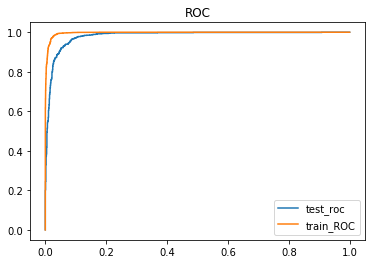

Probability density for train


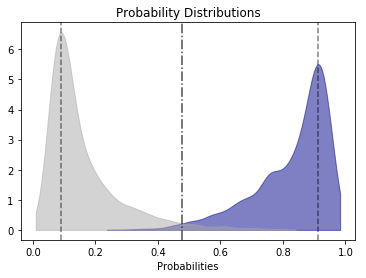

Probability density for test


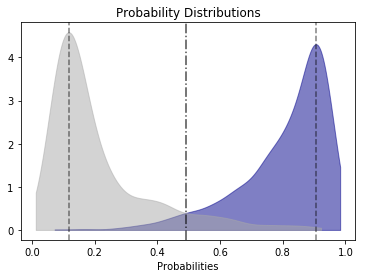


[[1050   94]
 [  46  964]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1050    94  1144
1            46   964  1010
All        1096  1058  2154


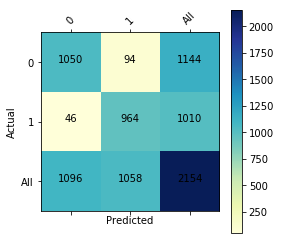


REPORT
             precision    recall  f1-score   support

          0       0.96      0.92      0.94      1144
          1       0.91      0.95      0.93      1010

avg / total       0.94      0.94      0.94      2154

ACCURACY =  0.9350046425255338
-----------------
TEST_GROUPS Counter({'5j7l.cif1_DA': 319, '6ha1.cif1_A': 297, '5mrc.cif1_A': 239, '5xy3.cif1_1': 223, '6ek0.cif1_S2': 163, '3j7a.cif1_A': 142, '5ngm.cif1_Aa': 138, '6gaz.cif1_AA': 82, '5t2a.cif1_B': 77, '2a64.cif1_A': 20, '4wf9.cif1_Y': 19, '3mxh.cif1_R': 18, '5ml7.cif1_B': 18, '5fjc.cif1_A': 17, '6eri.cif1_Ax': 16, '2qwy.cif1_C': 14, '3ndb.cif1_M': 11, '3v7e.cif1_C': 11, '1mfq.cif1_A': 10, '3d2v.cif1_A': 10, '3q3z.cif1_V': 10, '4uyk.cif1_R': 10, '5hr7.cif1_D': 10, '5t83.cif1_A': 10, '1n78.cif1_C': 9, '2csx.cif1_C': 9, '3g9c.cif1_Q': 9, '3j7q.cif1_8': 9, '3la5.cif1_A': 9, '4lvw.cif1_A': 9, '4prf.cif1_B': 9, '5aj0.cif1_Bv': 9, '5lzs.cif1_3': 9, '5zwn.cif1_P': 9, '1s03.cif1_A': 8, '1u0b.cif1_A': 8, '4jf2.cif1_A': 8, '4zn

112 B.A.-12.B.U.-8.B.G.-6. -_cWS_- 16.95_5.54_14.38 PROBA:  0.8477077864462531
CONFUSION MATRIX By chain:  5kk5.cif1_B
[[4 1]
 [0 1]]

110 1.U.2173.1.A.2184.1.U.2191. -_-_- 19.67_23.67_12.3 PROBA:  0.5669201002902464
111 1.U.280.1.C.1739.1.G.2238. -_tWS_cWW 9.95_8.87_10.72 PROBA:  0.433651542165639
111 1.A.502.1.U.2173.1.U.2191. cHW_-_cWW 9.74_12.3_9.58 PROBA:  0.41473634008362564
111 1.G.1238.1.G.1271.1.C.1291. tSS_-_cWH 8.63_5.95_10.92 PROBA:  0.3676322734454118
111 1.C.1606.1.A.1623.1.A.2705. cWW_-_tSH 10.63_5.41_9.4 PROBA:  0.4661050179331486
111 1.A.1827.1.G.2416.1.C.2425. cWS_cWW_- 6.14_10.77_12.51 PROBA:  0.47835476307869224
112 1.A.878.1.C.2070.1.G.2078. -_cWW_- 33.35_10.83_39.79 PROBA:  0.59508381593068
112 1.U.243.1.A.268.1.A.269. tWH_-_- 9.67_5.29_12.03 PROBA:  0.9283074067026311
CONFUSION MATRIX By chain:  5xy3.cif1_1
[[111   3]
 [  5 104]]

CONFUSION MATRIX By chain:  5ah5.cif1_D
[[5 0]
 [0 2]]

100 A.A.19.A.A.60.A.G.68. -_-_- 14.83_15.32_29.48 PROBA:  0.5173997506514278
1

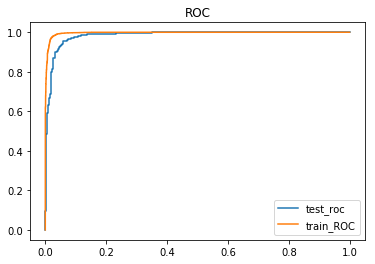

Probability density for train


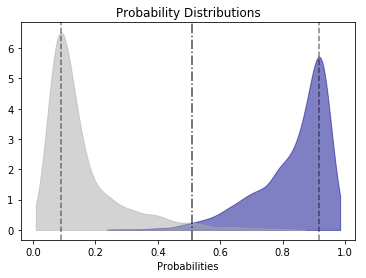

Probability density for test


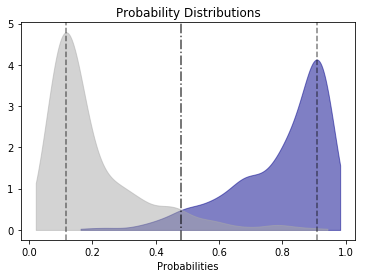


[[1074   64]
 [  59  957]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1074    64  1138
1            59   957  1016
All        1133  1021  2154


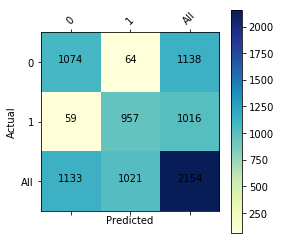


REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.95      1138
          1       0.94      0.94      0.94      1016

avg / total       0.94      0.94      0.94      2154

ACCURACY =  0.9428969359331476
-----------------
TEST_GROUPS Counter({'6ek0.cif1_L5': 299, '5o60.cif1_A': 297, '4wf9.cif1_X': 273, '6ha1.cif1_a': 188, '4lfb.cif1_A': 174, '6gaw.cif1_BA': 162, '5an9.cif1_N': 119, '5t5h.cif1_A': 101, '4p95.cif1_A': 26, '1u9s.cif1_A': 23, '1nbs.cif1_B': 21, '5j7l.cif1_DB': 20, '4gxy.cif1_A': 19, '4ycp.cif1_B': 18, '4kqy.cif1_A': 17, '4oqu.cif1_A': 17, '5tbw.cif1_AS': 15, '5ccb.cif1_N': 12, '2r8s.cif1_R': 11, '4lck.cif1_F': 11, '2d6f.cif1_F': 10, '3j79.cif1_C': 10, '3kfu.cif1_L': 10, '4aob.cif1_A': 10, '4mgn.cif1_A': 10, '6gaw.cif1_BB': 10, '1qtq.cif1_B': 9, '3skl.cif1_B': 9, '4gcw.cif1_B': 9, '4qk9.cif1_A': 9, '4qlm.cif1_A': 9, '5e81.cif1_1K': 9, '5mrc.cif1_bb': 9, '5oql.cif1_2': 9, '5tbw.cif1_4': 9, '5wwt.cif1_C': 9, '6ek0.cif1_L8': 9,

123 F.G.912.F.U.925.F.A.947. -_-_- 7.43_14.37_12.94 PROBA:  0.7850596338191959
112 F.G.912.F.U.925.F.G.945. -_cWW_- 7.43_12.71_14.79 PROBA:  0.751447201067418
CONFUSION MATRIX By chain:  2d6f.cif1_F
[[4 2]
 [0 4]]

112 B.A.914.B.A.921.B.A.945. cWS_-_- 9.71_7.78_14.45 PROBA:  0.5022377706895566
CONFUSION MATRIX By chain:  1qtq.cif1_B
[[4 1]
 [0 4]]

110 A.G.40.A.C.91.A.U.93. cWW_-_- 10.63_10.78_6.91 PROBA:  0.5252057474529339
112 A.G.40.A.A.45.A.C.91. -_-_cWW 24.04_22.38_10.63 PROBA:  0.5019477913908308
CONFUSION MATRIX By chain:  4qlm.cif1_A
[[3 2]
 [0 4]]

CONFUSION MATRIX By chain:  3hjw.cif1_D
[[2]]

CONFUSION MATRIX By chain:  6ek0.cif1_L8
[[6 0]
 [0 3]]

112 A.U.20.A.A.21.A.U.75. -_cWW_- 5.62_10.46_13.48 PROBA:  0.6066890583712168
CONFUSION MATRIX By chain:  4lx6.cif1_A
[[3 1]
 [0 3]]

CONFUSION MATRIX By chain:  4qk9.cif1_A
[[5 0]
 [0 4]]

110 X.U.1802.X.A.1816.X.U.2623. -_-_- 11.7_30.4_41.25 PROBA:  0.516754585704131
110 X.G.2262.X.C.2290.X.G.2304. -_cWW_- 62.86_10.45_61.61 PROB

AUC_TRAIN =  0.9971314735780729

AUC =  0.9828027733802608


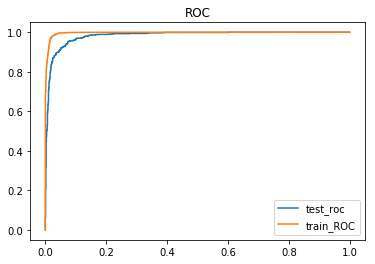

Probability density for train


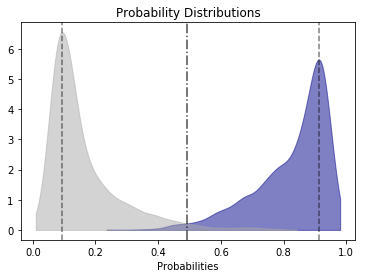

Probability density for test


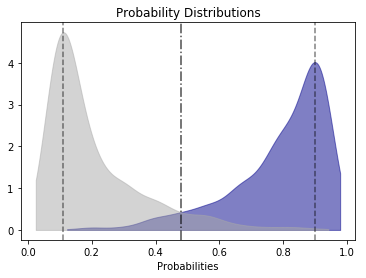


[[1065   76]
 [  69  943]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1065    76  1141
1            69   943  1012
All        1134  1019  2153


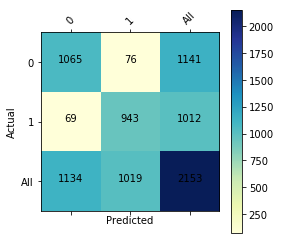


REPORT
             precision    recall  f1-score   support

          0       0.94      0.93      0.94      1141
          1       0.93      0.93      0.93      1012

avg / total       0.93      0.93      0.93      2153

ACCURACY =  0.9326521133302369
-----------------


In [6]:
groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=5)
#group_kfold.get_n_splits(X, y, groups)

description = ['type', 'dssrs', 'bps', 'dists']

for train_index, test_index in group_kfold.split(triplexes, triplexes_target, groups):
    #triplexes_data = triplexes.iloc[:, 5:475]
    #print(triplexes_data)
    X_train_middle, X_test_middle = triplexes.loc[list(train_index)], triplexes.loc[test_index]
    X_train = X_train_middle.iloc[:, 5:475]
    X_test = X_test_middle.iloc[:, 5:475]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]

    
    a = Counter(list(triplexes.loc[list(train_index)].pdb_chain.values))
    b = Counter(list(triplexes.loc[list(test_index)].pdb_chain.values))
    
    for key in a:
        if key in b.keys():
            print("FUUUUUUUUU")
    print("TEST_GROUPS", Counter(list(triplexes.pdb_chain.loc[test_index])))
    rf_classifier_cv.fit(X_train, y_train)
    
    #prediction by chains
    chains = list(set(X_test_middle.pdb_chain.values))

    print("")
    for chain in chains:
        middle_check_test = X_test_middle.loc[X_test_middle['pdb_chain'] == chain]
        middle_target_test = middle_check_test['istriple']
        middle_check_test_ = middle_check_test.iloc[:, 5:475]
    
        prediction_result_by_chain = rf_classifier_cv.predict(middle_check_test_)
        predict_proba_by_chain = rf_classifier_cv.predict_proba(middle_check_test_)

        
        #PREDICTED PROBABILITIES
        i = 0
        for index, row in middle_check_test.iterrows():
            if middle_target_test[index] != prediction_result_by_chain[i]:
                print(row['type'], row['dssrs'], row['bps'], row['dists'], "PROBA: ", predict_proba_by_chain[i][1])
            i = i + 1

        print("CONFUSION MATRIX By chain: ", chain)
        print(confusion_matrix(middle_target_test, prediction_result_by_chain))
        print("")
    
    #simple prediction
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY = ", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.996781032507539

AUC =  0.9838383141630309


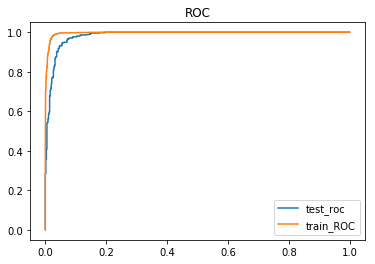

Probability density for train


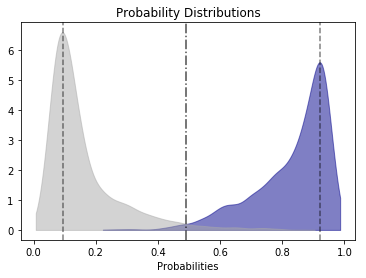

Probability density for test


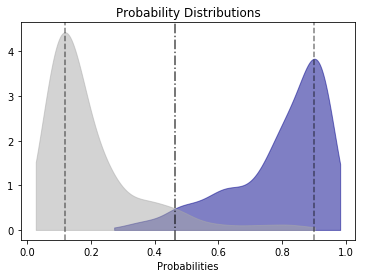


[[533  30]
 [ 34 481]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          533   30   563
1           34  481   515
All        567  511  1078


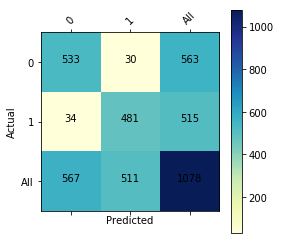

REPORT
             precision    recall  f1-score   support

          0       0.94      0.95      0.94       563
          1       0.94      0.93      0.94       515

avg / total       0.94      0.94      0.94      1078

ACCURACY 0.9406307977736549
-----------------

AUC_TRAIN =  0.9966583065032003

AUC =  0.985752596320111


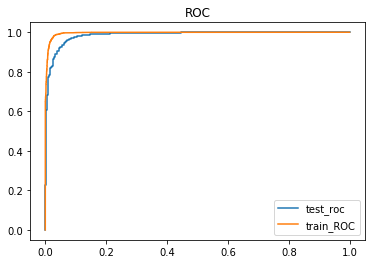

Probability density for train


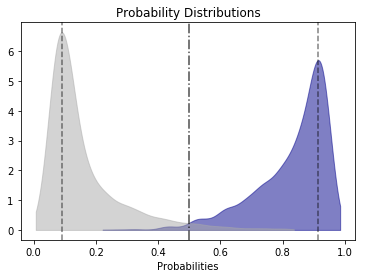

Probability density for test


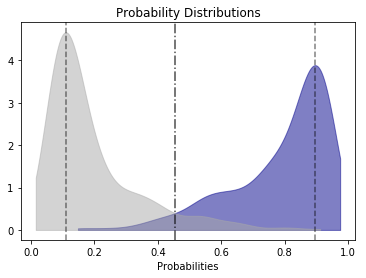


[[532  35]
 [ 31 480]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          532   35   567
1           31  480   511
All        563  515  1078


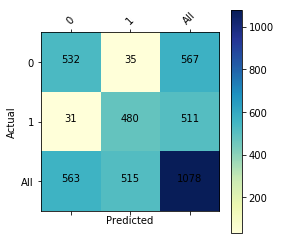

REPORT
             precision    recall  f1-score   support

          0       0.94      0.94      0.94       567
          1       0.93      0.94      0.94       511

avg / total       0.94      0.94      0.94      1078

ACCURACY 0.9387755102040817
-----------------

AUC_TRAIN =  0.9962728125324635

AUC =  0.9821774143204943


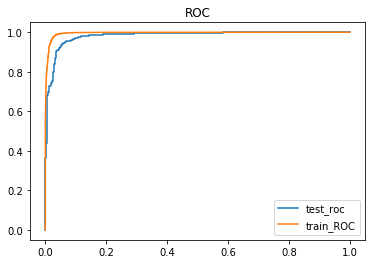

Probability density for train


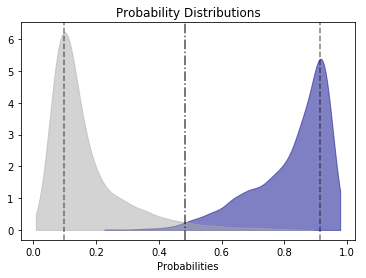

Probability density for test


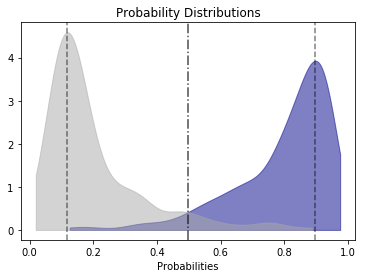


[[542  37]
 [ 25 473]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          542   37   579
1           25  473   498
All        567  510  1077


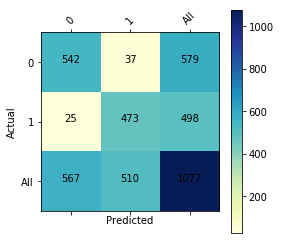

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       579
          1       0.93      0.95      0.94       498

avg / total       0.94      0.94      0.94      1077

ACCURACY 0.9424326833797586
-----------------

AUC_TRAIN =  0.997050877054684

AUC =  0.9840995877030355


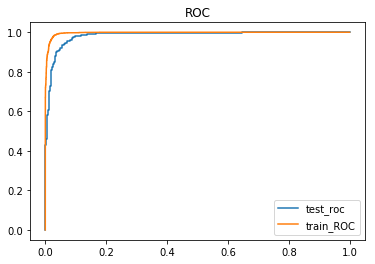

Probability density for train


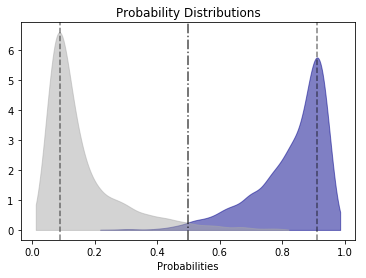

Probability density for test


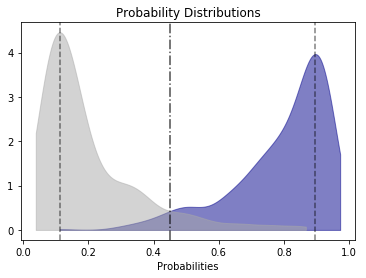


[[536  32]
 [ 33 476]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          536   32   568
1           33  476   509
All        569  508  1077


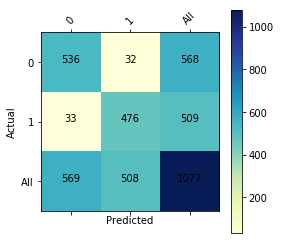

REPORT
             precision    recall  f1-score   support

          0       0.94      0.94      0.94       568
          1       0.94      0.94      0.94       509

avg / total       0.94      0.94      0.94      1077

ACCURACY 0.9396471680594243
-----------------

AUC_TRAIN =  0.9968341502090026

AUC =  0.9836728756381571


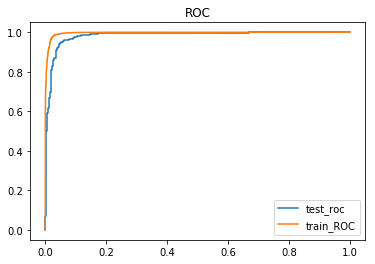

Probability density for train


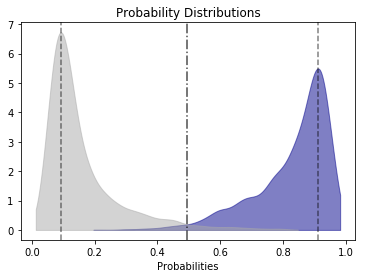

Probability density for test


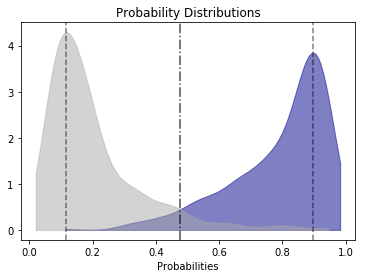


[[547  27]
 [ 29 474]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          547   27   574
1           29  474   503
All        576  501  1077


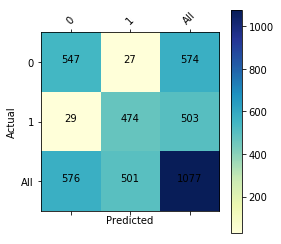

REPORT
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       574
          1       0.95      0.94      0.94       503

avg / total       0.95      0.95      0.95      1077

ACCURACY 0.9480037140204272
-----------------

AUC_TRAIN =  0.9967915622245818

AUC =  0.9842312109931778


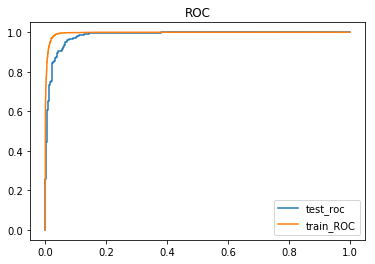

Probability density for train


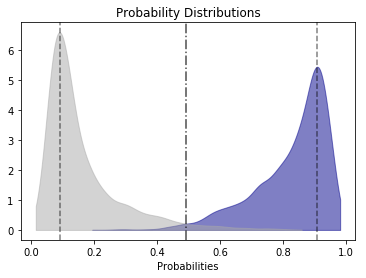

Probability density for test


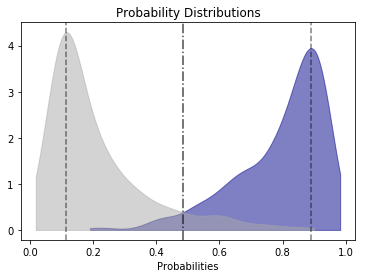


[[529  40]
 [ 23 485]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          529   40   569
1           23  485   508
All        552  525  1077


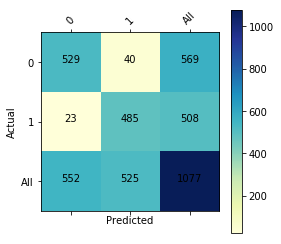

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.94       569
          1       0.92      0.95      0.94       508

avg / total       0.94      0.94      0.94      1077

ACCURACY 0.9415041782729805
-----------------

AUC_TRAIN =  0.9968890051685106

AUC =  0.9820886207613897


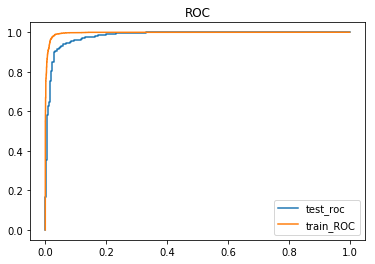

Probability density for train


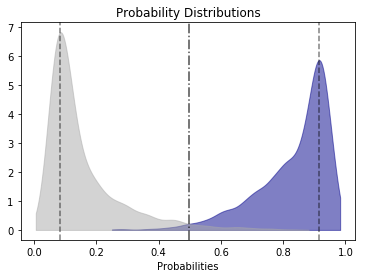

Probability density for test


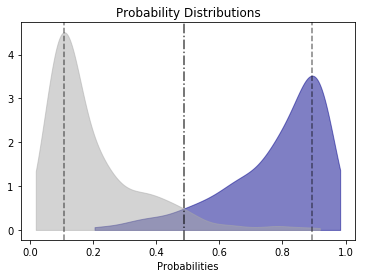


[[541  29]
 [ 39 467]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          541   29   570
1           39  467   506
All        580  496  1076


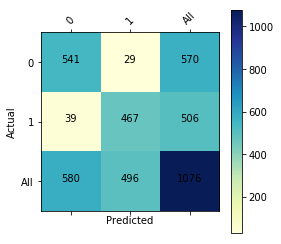

REPORT
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       570
          1       0.94      0.92      0.93       506

avg / total       0.94      0.94      0.94      1076

ACCURACY 0.9368029739776952
-----------------

AUC_TRAIN =  0.996737280702841

AUC =  0.9914014018173759


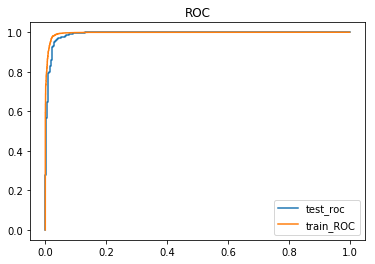

Probability density for train


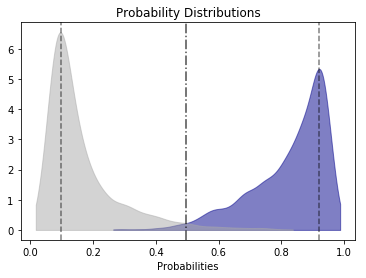

Probability density for test


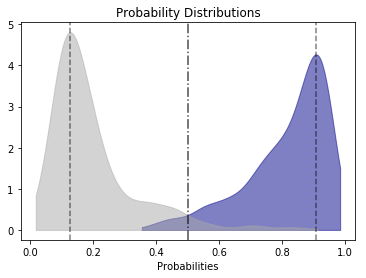


[[542  22]
 [ 17 495]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          542   22   564
1           17  495   512
All        559  517  1076


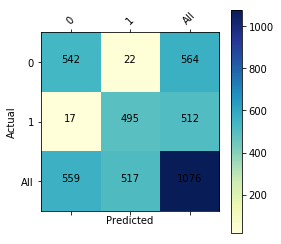

REPORT
             precision    recall  f1-score   support

          0       0.97      0.96      0.97       564
          1       0.96      0.97      0.96       512

avg / total       0.96      0.96      0.96      1076

ACCURACY 0.9637546468401487
-----------------

AUC_TRAIN =  0.9970588700223186

AUC =  0.9800566348643671


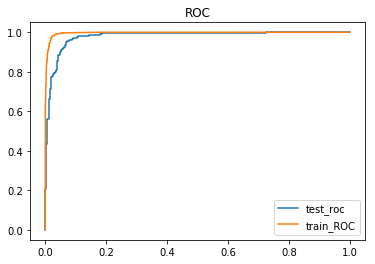

Probability density for train


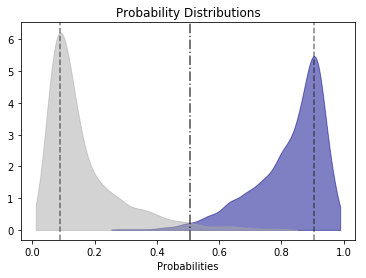

Probability density for test


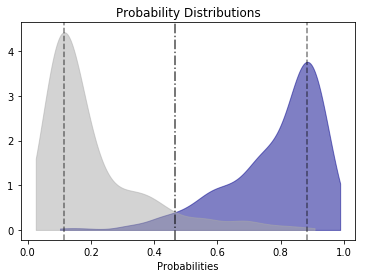


[[523  39]
 [ 30 484]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          523   39   562
1           30  484   514
All        553  523  1076


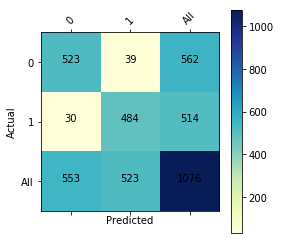

REPORT
             precision    recall  f1-score   support

          0       0.95      0.93      0.94       562
          1       0.93      0.94      0.93       514

avg / total       0.94      0.94      0.94      1076

ACCURACY 0.9358736059479554
-----------------

AUC_TRAIN =  0.9967980184885481

AUC =  0.9864310436911723


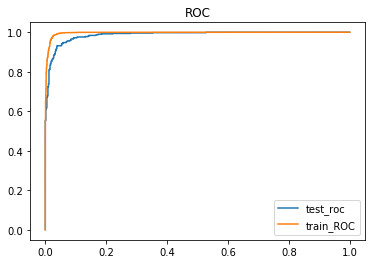

Probability density for train


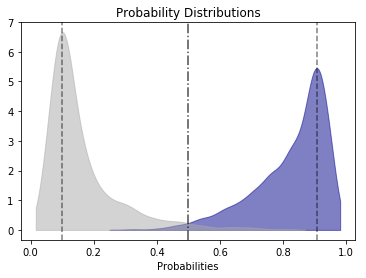

Probability density for test


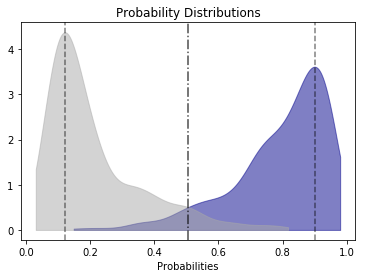


[[541  38]
 [ 26 472]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          541   38   579
1           26  472   498
All        567  510  1077


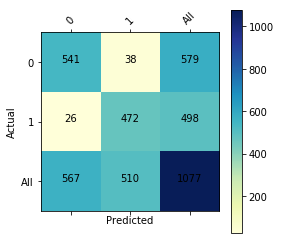

REPORT
             precision    recall  f1-score   support

          0       0.95      0.93      0.94       579
          1       0.93      0.95      0.94       498

avg / total       0.94      0.94      0.94      1077

ACCURACY 0.9405756731662024
-----------------


In [7]:
# 10 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=10)
#group_kfold.get_n_splits(X, y, groups)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.9966034890453725

AUC =  0.9851194411817326


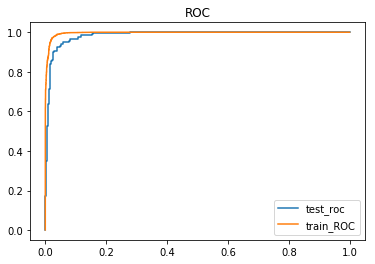

Probability density for train


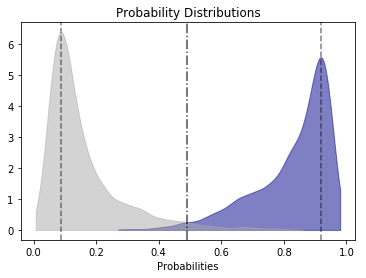

Probability density for test


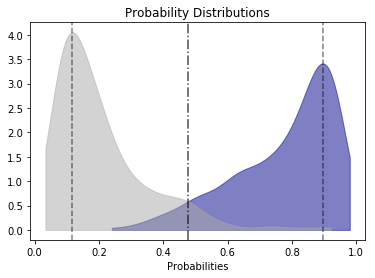


[[359  18]
 [ 25 316]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          359   18  377
1           25  316  341
All        384  334  718


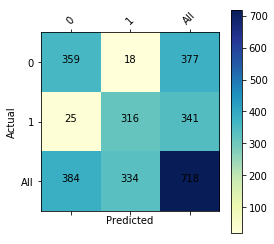

REPORT
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       377
          1       0.95      0.93      0.94       341

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9401114206128134
-----------------

AUC_TRAIN =  0.9968101060550201

AUC =  0.9862815322329492


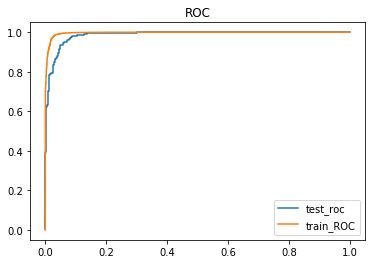

Probability density for train


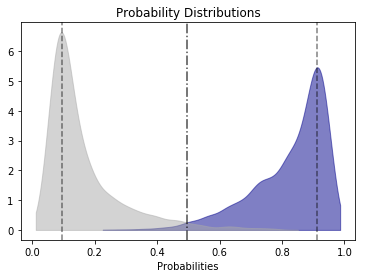

Probability density for test


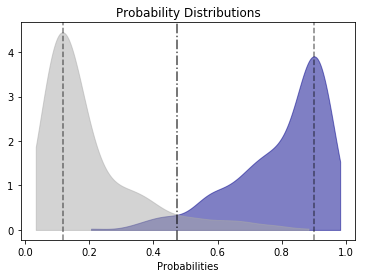


[[355  25]
 [ 16 322]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          355   25  380
1           16  322  338
All        371  347  718


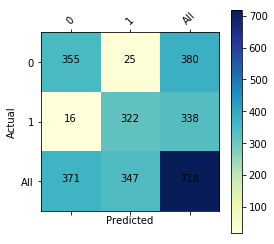

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.95       380
          1       0.93      0.95      0.94       338

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9428969359331476
-----------------

AUC_TRAIN =  0.9966039157643518

AUC =  0.9853184256487025


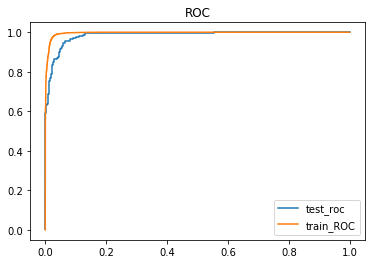

Probability density for train


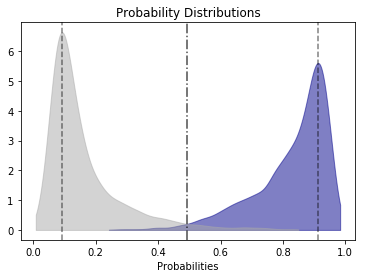

Probability density for test


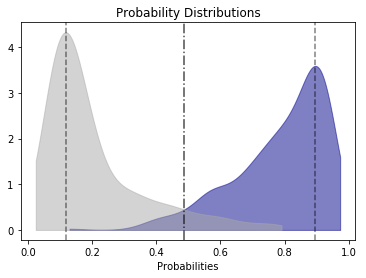


[[359  25]
 [ 16 318]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          359   25  384
1           16  318  334
All        375  343  718


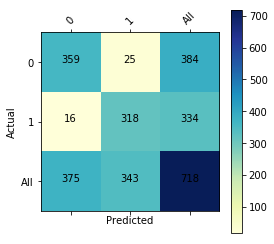

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.95       384
          1       0.93      0.95      0.94       334

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9428969359331476
-----------------

AUC_TRAIN =  0.9966399110093938

AUC =  0.981371540762902


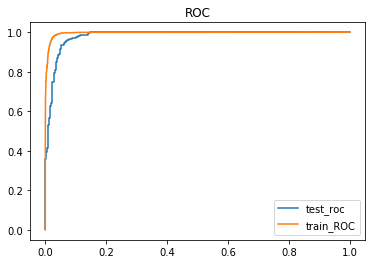

Probability density for train


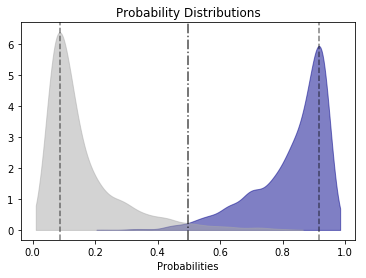

Probability density for test


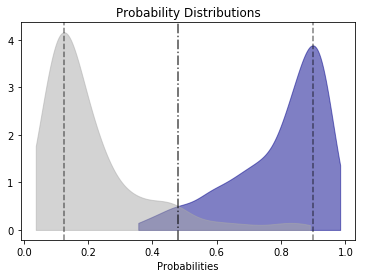


[[358  24]
 [ 21 315]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          358   24  382
1           21  315  336
All        379  339  718


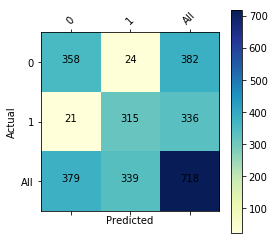

REPORT
             precision    recall  f1-score   support

          0       0.94      0.94      0.94       382
          1       0.93      0.94      0.93       336

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9373259052924791
-----------------

AUC_TRAIN =  0.9968296914329664

AUC =  0.9876362503892868


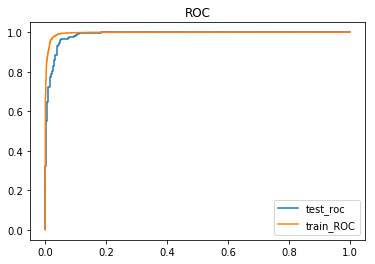

Probability density for train


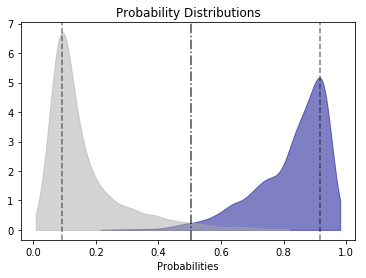

Probability density for test


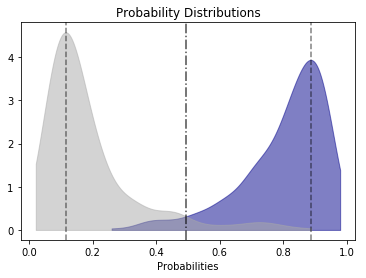


[[362  18]
 [ 13 325]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          362   18  380
1           13  325  338
All        375  343  718


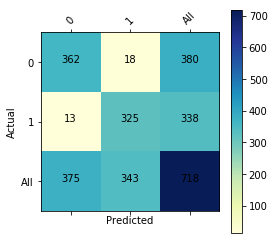

REPORT
             precision    recall  f1-score   support

          0       0.97      0.95      0.96       380
          1       0.95      0.96      0.95       338

avg / total       0.96      0.96      0.96       718

ACCURACY 0.9568245125348189
-----------------

AUC_TRAIN =  0.9968003047037508

AUC =  0.9847727980080923


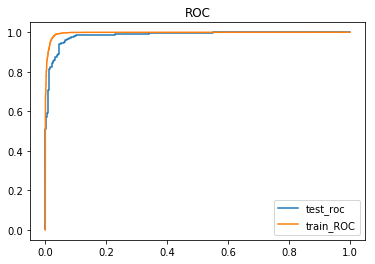

Probability density for train


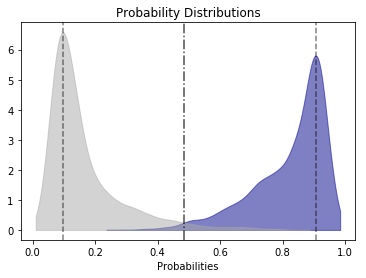

Probability density for test


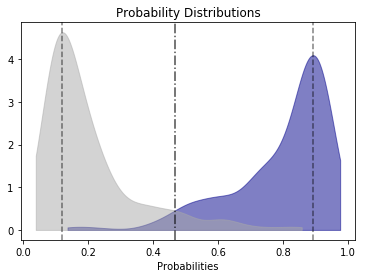


[[357  21]
 [ 19 321]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          357   21  378
1           19  321  340
All        376  342  718


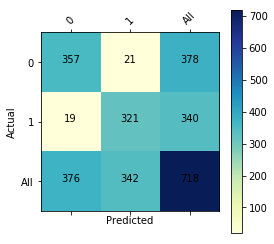

REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       378
          1       0.94      0.94      0.94       340

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9442896935933147
-----------------

AUC_TRAIN =  0.9965939141903879

AUC =  0.9810123136040823


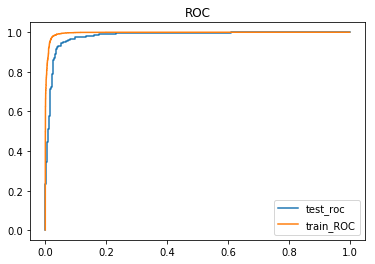

Probability density for train


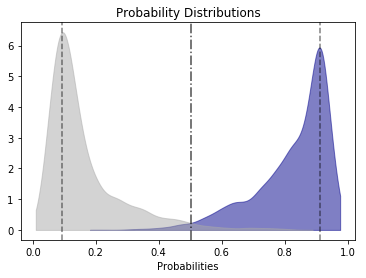

Probability density for test


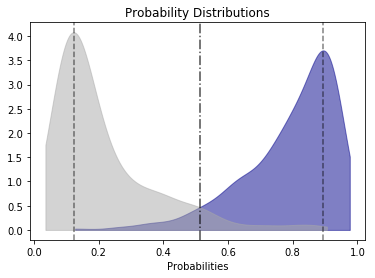


[[351  26]
 [ 15 326]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          351   26  377
1           15  326  341
All        366  352  718


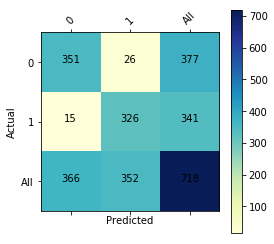

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.94       377
          1       0.93      0.96      0.94       341

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9428969359331476
-----------------

AUC_TRAIN =  0.9970006834152393

AUC =  0.9895873114843536


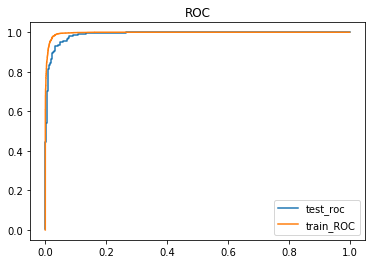

Probability density for train


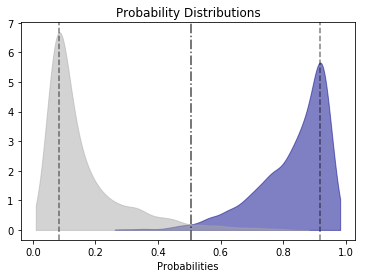

Probability density for test


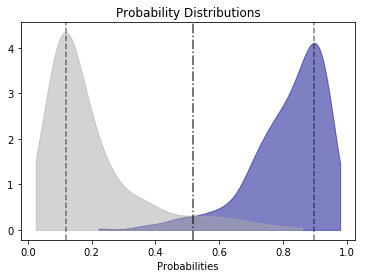


[[355  28]
 [ 11 324]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          355   28  383
1           11  324  335
All        366  352  718


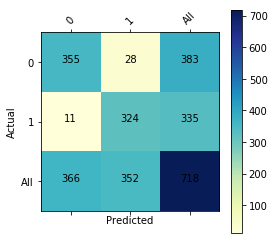

REPORT
             precision    recall  f1-score   support

          0       0.97      0.93      0.95       383
          1       0.92      0.97      0.94       335

avg / total       0.95      0.95      0.95       718

ACCURACY 0.9456824512534819
-----------------

AUC_TRAIN =  0.9965531920134313

AUC =  0.9852818704711203


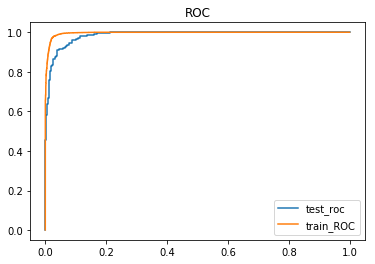

Probability density for train


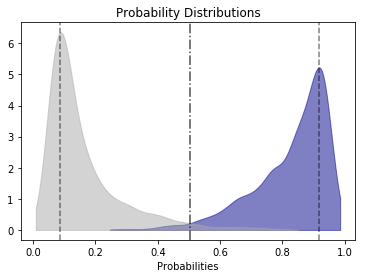

Probability density for test


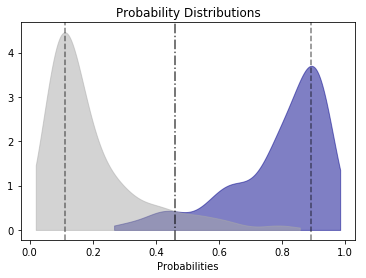


[[354  25]
 [ 26 313]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          354   25  379
1           26  313  339
All        380  338  718


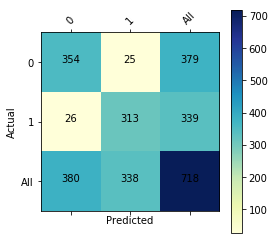

REPORT
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       379
          1       0.93      0.92      0.92       339

avg / total       0.93      0.93      0.93       718

ACCURACY 0.9289693593314763
-----------------

AUC_TRAIN =  0.9961757032159146

AUC =  0.98381404263276


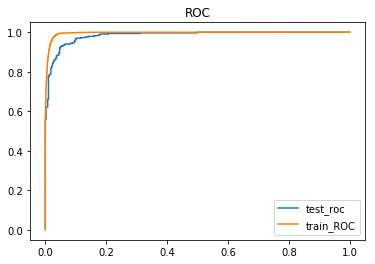

Probability density for train


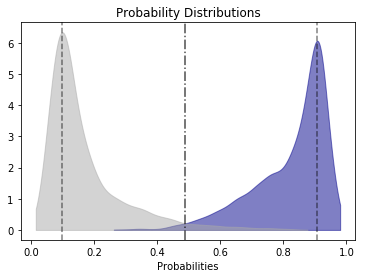

Probability density for test


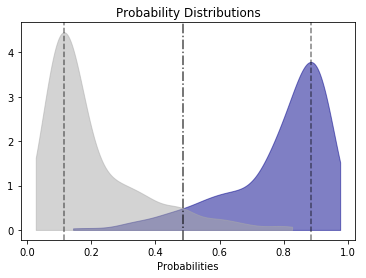


[[362  20]
 [ 24 312]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          362   20  382
1           24  312  336
All        386  332  718


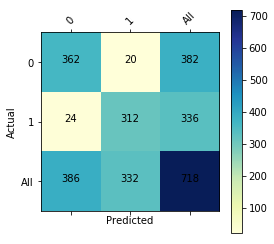

REPORT
             precision    recall  f1-score   support

          0       0.94      0.95      0.94       382
          1       0.94      0.93      0.93       336

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9387186629526463
-----------------

AUC_TRAIN =  0.9969083349470209

AUC =  0.98314366390006


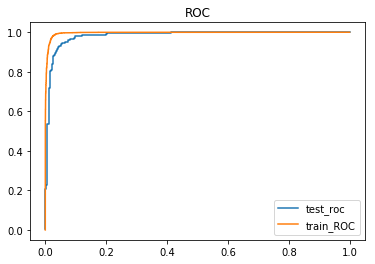

Probability density for train


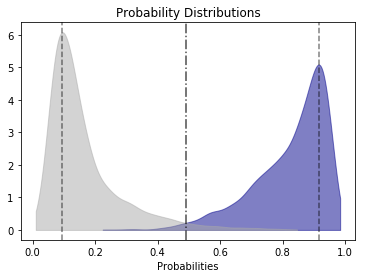

Probability density for test


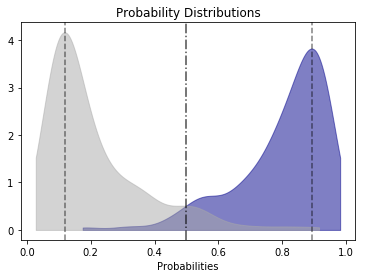


[[348  29]
 [ 13 328]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          348   29  377
1           13  328  341
All        361  357  718


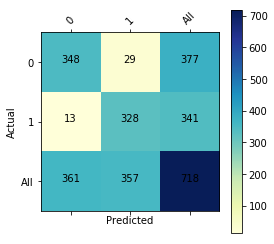

REPORT
             precision    recall  f1-score   support

          0       0.96      0.92      0.94       377
          1       0.92      0.96      0.94       341

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9415041782729805
-----------------

AUC_TRAIN =  0.9960572729510644

AUC =  0.984509145203434


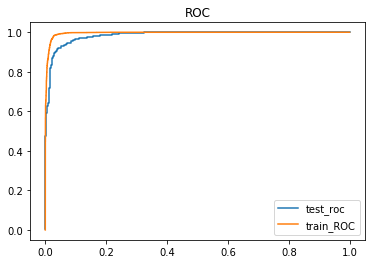

Probability density for train


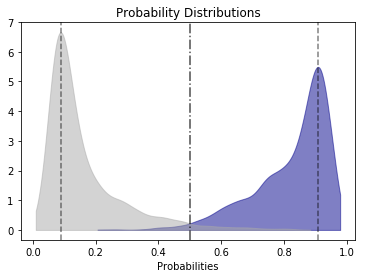

Probability density for test


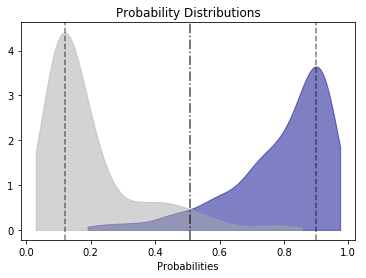


[[353  23]
 [ 22 320]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          353   23  376
1           22  320  342
All        375  343  718


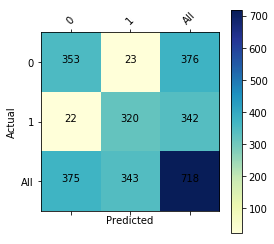

REPORT
             precision    recall  f1-score   support

          0       0.94      0.94      0.94       376
          1       0.93      0.94      0.93       342

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9373259052924791
-----------------

AUC_TRAIN =  0.9965857670089541

AUC =  0.9798281891321449


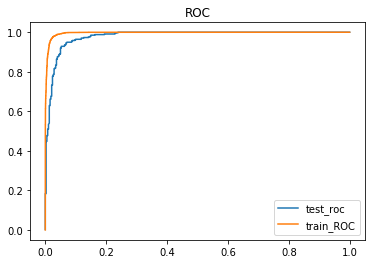

Probability density for train


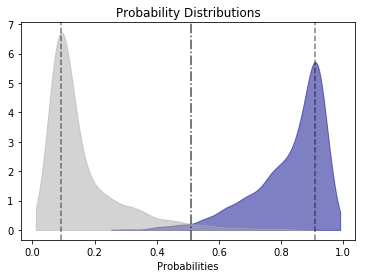

Probability density for test


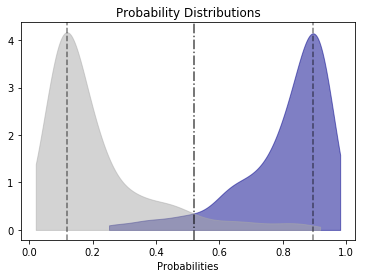


[[354  27]
 [ 17 320]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          354   27  381
1           17  320  337
All        371  347  718


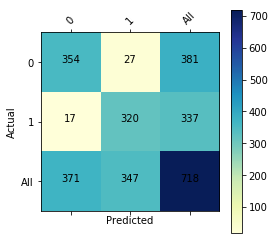

REPORT
             precision    recall  f1-score   support

          0       0.95      0.93      0.94       381
          1       0.92      0.95      0.94       337

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9387186629526463
-----------------

AUC_TRAIN =  0.9964861672745441

AUC =  0.9859984287125555


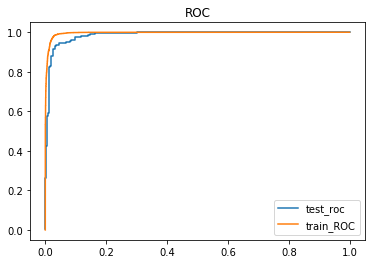

Probability density for train


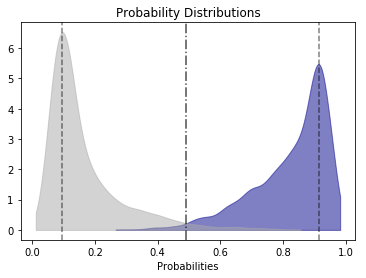

Probability density for test


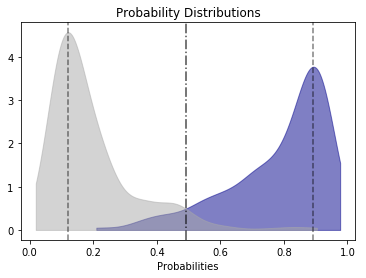


[[362  15]
 [ 22 319]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          362   15  377
1           22  319  341
All        384  334  718


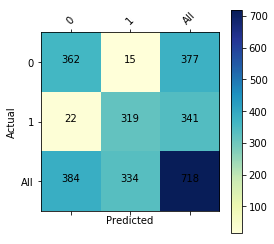

REPORT
             precision    recall  f1-score   support

          0       0.94      0.96      0.95       377
          1       0.96      0.94      0.95       341

avg / total       0.95      0.95      0.95       718

ACCURACY 0.9484679665738162
-----------------

AUC_TRAIN =  0.9971765178651606

AUC =  0.9746815659920293


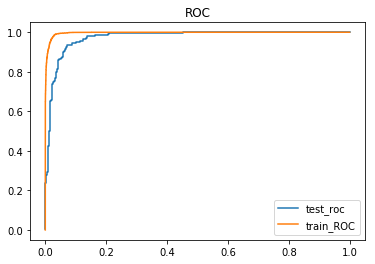

Probability density for train


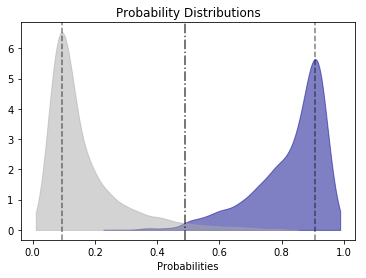

Probability density for test


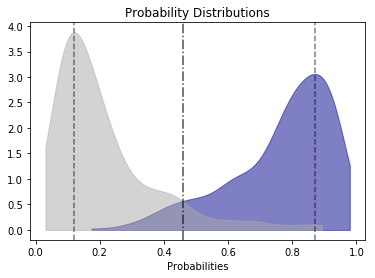


[[357  25]
 [ 31 304]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          357   25  382
1           31  304  335
All        388  329  717


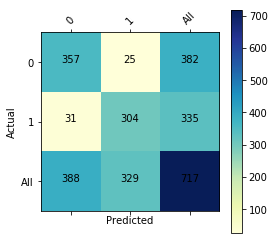

REPORT
             precision    recall  f1-score   support

          0       0.92      0.93      0.93       382
          1       0.92      0.91      0.92       335

avg / total       0.92      0.92      0.92       717

ACCURACY 0.9218967921896792
-----------------


In [8]:
# 15 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=15)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_prob_train[:, 1])
    auc_train = metrics.roc_auc_score(y_train, prediction_prob_train[:, 1])
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob[:, 1])
    auc = metrics.roc_auc_score(y_test, prediction_prob[:, 1])
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")
